Start a main function

In [ ]:
#start a main function

: 

In [2]:
import numpy as np
import warnings

In [3]:
def lininterp2_vec_v2(X, Y, V, x, y):
    """
    Perform bilinear interpolation, given grid vectors X, Y and a matrix V of values,
    plus query arrays x and y.
    
    The input arrays X and Y must be strictly increasing.
    
    Parameters
    ----------
    X : array-like, shape (n,)
        1D array of x coordinates (grid lines). Must be strictly increasing.
    Y : array-like, shape (m,)
        1D array of y coordinates (grid lines). Must be strictly increasing.
    V : 2D array, shape (n, m)
        2D array of function values defined on the grid of X and Y.
        The number of rows must equal len(X) and the number of columns must equal len(Y).
    x : array-like, shape (k,)
        Query points in the x direction.
    y : array-like, shape (k,)
        Query points in the y direction.
    
    Returns
    -------
    v : ndarray, shape (k,)
        Interpolated values at each (x, y) query.
    
    Raises
    ------
    ValueError
        If the sizes of X, Y, and V are inconsistent or if any x is outside the range of X.
    """
    # Convert inputs to 1D numpy arrays as needed
    X = np.atleast_1d(np.squeeze(np.array(X)))
    Y = np.atleast_1d(np.squeeze(np.array(Y)))
    x = np.atleast_1d(np.squeeze(np.array(x)))
    y = np.atleast_1d(np.squeeze(np.array(y)))
    
    # Verify that the dimensions of V match the lengths of X and Y
    if X.size != V.shape[0] or Y.size != V.shape[1]:
        raise ValueError(f"[len(X), len(Y)] does not match size(V). Got len(X)={X.size}, len(Y)={Y.size}, "
                         f"but V.shape={V.shape}")
    
    # For consistency with MATLAB behavior, ensure X and Y are column-like
    # (not strictly needed in Python, but we enforce 1D arrays)
    
    # --- Process x coordinate ---
    # Ensure x values are within bounds; MATLAB discretize would return NaN otherwise.
    if np.any(x < X[0]) or np.any(x > X[-1]) or np.any(x == X[-1]):
        raise ValueError(f"Input x values (min={x.min()}, max={x.max()}) are outside the range described by "
                         f"X[0]={X[0]} and X[-1]={X[-1]}.")
    
    # Determine the bin indices for x.
    # np.searchsorted with 'right' returns the first index where x would be inserted to maintain order.
    # Subtract 1 to get the index of the lower bound.
    pindexx = np.searchsorted(X, x, side='right') - 1
    indexx = pindexx + 1  # Upper index
    
    # Calculate the relative distance between the grid points
    X_lower = X[pindexx]
    X_upper = X[indexx]
    slopex = (x - X_lower) / (X_upper - X_lower)
    
    # --- Process y coordinate ---
    # For y, if out-of-bound values occur, issue a warning and assign y to the boundary values.
    pindexy = np.searchsorted(Y, y, side='right') - 1
    indexy = pindexy + 1
    
    # Find indices where y is out-of-bound. Use a mask for below and above range.
    below_mask = y < Y[0]
    above_mask = y > Y[-1]
    
    if np.any(below_mask) or np.any(above_mask):
        warnings.warn(f"Input y values (min={y.min()}, max={y.max()}) are outside the range described by "
                      f"Y[0]={Y[0]} and Y[-1]={Y[-1]}. Values below Y[0] are set to Y[0] and above Y[-1] are set to Y[-1].")
        # For values above the range:
        idx_above = np.where(above_mask)[0]
        pindexy[idx_above] = Y.size - 2  # lower index is second-last index
        indexy[idx_above] = Y.size - 1   # upper index is last index
        y[idx_above] = Y[-1]
        # For values below the range:
        idx_below = np.where(below_mask)[0]
        pindexy[idx_below] = 0
        indexy[idx_below] = 1
        y[idx_below] = Y[0]
    
    Y_lower = Y[pindexy]
    Y_upper = Y[indexy]
    slopey = (y - Y_lower) / (Y_upper - Y_lower)
    
    # --- Bilinear interpolation ---
    # For a query point, the bilinear interpolation is:
    # v = V(x_low, y_low)*(1-slopex)*(1-slopey) +
    #     V(x_high, y_low)*slopex*(1-slopey) +
    #     V(x_low, y_high)*(1-slopex)*slopey +
    #     V(x_high, y_high)*slopex*slopey
    v = (V[pindexx, pindexy] * (1 - slopex) * (1 - slopey) +
         V[indexx, pindexy]   * slopex       * (1 - slopey) +
         V[pindexx, indexy]   * (1 - slopex) * slopey +
         V[indexx, indexy]    * slopex       * slopey)
    
    return v


/var/folders/j4/blvnfny95895_xf1tllbqhkh0000gn/T/ipykernel_12006/3984148643.py:73: UserWarning: Input y values (min=2458854.5, max=2458854.5) are outside the range described by Y[0]=2458908.5 and Y[-1]=2533388.5. Values below Y[0] are set to Y[0] and above Y[-1] are set to Y[-1].
  warnings.warn(f"Input y values (min={y.min()}, max={y.max()}) are outside the range described by "


MATLAB output:
[2.40993749e-07 1.82504526e-07 1.96049026e-07 ... 4.62196990e-05
 3.80559004e-07 5.34652160e-07]

Python output:
[2.40993749e-07 1.82504526e-07 1.96049026e-07 ... 4.62196990e-05
 3.80559004e-07 5.34652160e-07]

The Python output matches the MATLAB output within the tolerance.


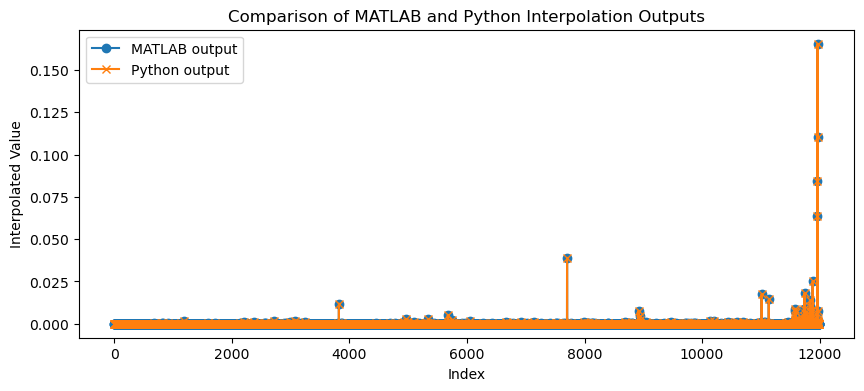

In [ ]:
import scipy.io
from scipy.interpolate import RegularGridInterpolator

# Load the MATLAB data:
data = scipy.io.loadmat('lininterp2_test.mat')
X = np.squeeze(data['X'])
Y = np.squeeze(data['Y'])
V = data['V']
x = np.squeeze(data['x'])
y = np.squeeze(data['y'])
v_matlab = np.squeeze(data['v_matlab'])

# Compute using the Python function (if required, multiply by 1e9)
v_python = lininterp2_vec_v2(X, Y, V, x, y) * 1e9

# Display and compare the outputs
print("MATLAB output:")
print(v_matlab)
print("\nPython output:")
print(v_python)
# print("\nScipy output:")
# print(v_scipy)

# Check if they are nearly equal
try:
    np.testing.assert_allclose(v_python, v_matlab, rtol=1e-6, atol=1e-8)
    print("\nThe Python output matches the MATLAB output within the tolerance.")
except AssertionError as e:
    print("\nThere is a difference between the MATLAB and Python outputs:")
    print(e)

# Optionally, plot both outputs for visual comparison:
plt.figure(figsize=(10, 4))
plt.plot(v_matlab, 'o-', label="MATLAB output")
plt.plot(v_python, 'x-', label="Python output")
plt.xlabel("Index")
plt.ylabel("Interpolated Value")
plt.legend()
plt.title("Comparison of MATLAB and Python Interpolation Outputs")
plt.show()

In [19]:
y

array(2458854.5)

In [ ]:
def analytic_propagation_vec(input_oe, param):
    """
    Propagates the mean orbital elements forward in time using the analytic model 
    for near-circular orbits in an atmosphere (based on Martinusi et al. 2015).
    
    Parameters
    ----------
    input_oe : numpy.ndarray
        Input mean orbital elements array of shape (n,6) with columns:
         [a, e, inc, Ω, ω, M].  (a: semi-major axis, e: eccentricity, 
         inc: inclination, Ω: right ascension, ω: argument of perigee, M: mean anomaly)
    param : dict
        Dictionary containing the required parameters:
            'req'             : Reference length (e.g. Earth's radius) [km]
            'j2'              : Second zonal harmonic coefficient
            'mu'              : Gravitational parameter [km^3/s^2]
            'density_profile' : String, either 'JB2008' or 'static'
            'alt'             : 2D array of altitude values for density interpolation [km]
            'dens_times'      : 2D array of times (or date vector) associated with the density values
            'dens_value'      : 2D array of density values (assumed to be in appropriate units)
            'jd'              : Current Julian date used for interpolation
            't'               : Propagation time (seconds)
            't_0'             : Initial time (seconds)
            'Bstar'           : Ballistic coefficient (passed already scaled and computed elsewhere)
    
    Returns
    -------
    out_oe : numpy.ndarray
        Propagated orbital elements with columns: 
         [a, e, mod(inc,2π), mod(Ω,2π), mod(ω,2π), mod(M,2π)]
    errors : numpy.ndarray
        Error flag vector (1 indicates a problem) of shape (n,).
    """
    n_sat = input_oe.shape[0]
    errors = np.zeros(n_sat)
    
    # Retrieve fundamental parameters
    re = param['req']
    J2 = param['j2']
    mu = param['mu']
    
    # Extract initial semi-major axis and compute altitude above re
    a_0 = input_oe[:, 0]
    a_minus_re = a_0 - re
    
    # Compute density based on the chosen profile
    if param['density_profile'].lower() == 'jb2008':
        rho_0 = np.zeros_like(a_0)
        # Identify indices for interpolation limits
        check_above = a_minus_re > param['alt'][-1, 0]
        check_below = a_minus_re < param['alt'][0, 0]
        check_in_range = (~check_above) & (~check_below)
        # Perform 2D interpolation for in-range values (assumed units conversion applied)
        rho_0[check_in_range] = lininterp2_vec_v2(param['alt'][:, 0],
                                                  param['dens_times'][0, :],
                                                  param['dens_value'],
                                                  a_minus_re[check_in_range],
                                                  param['jd']) * 1e9
        # Interpolate for values above and below using 1D interpolation
        rho_0[check_above] = lininterp1_vec(param['dens_times'][0, :],
                                            param['dens_value'][-1, :],
                                            param['jd']) * 1e9
        rho_0[check_below] = lininterp1_vec(param['dens_times'][0, :],
                                            param['dens_value'][0, :],
                                            param['jd']) * 1e9
    elif param['density_profile'].lower() == 'static':
        rho_0 = densityexp_vec(a_minus_re) * 1e9
    else:
        raise ValueError('Unknown density_profile in param dictionary')
    
    # Compute C_0 with a lower limit to avoid singularities.
    # Bstar is scaled with a reference density of 0.157 kg/(m^2*re) and converted from m^2 to km^2.
    C_0 = np.maximum((param['Bstar'] / (1e6 * 0.157)) * rho_0, 1e-20)
    
    # Compute common scaling parameter
    k2_over_mu = J2 * re**2 / 2  # k2 = mu * J2 * re^2 / 2
    t = param['t']
    t_0 = param['t_0']
    
    # Initial orbital elements
    e_0    = input_oe[:, 1]
    inc_0  = input_oe[:, 2]
    bigO_0 = input_oe[:, 3]  # Right ascension (Ω)
    omega_0= input_oe[:, 4]  # Argument of perigee (ω)
    Mo_0   = input_oe[:, 5]  # Mean anomaly (M)
    
    c = np.cos(inc_0)
    c_sq = c**2
    
    # Mean motion
    n_0 = np.sqrt(mu) * a_0**(-1.5)
    
    alpha0_sq = (e_0 / np.sqrt(a_0))**2
    beta_0 = (np.sqrt(3) / 2) * e_0
    
    # Compute reduction factors for a and e, ensuring a lower limit of zero.
    tan_atan_beta0 = np.maximum(
        np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0)), 0)
    
    # Propagate semi-major axis and eccentricity
    a = (a_0 / (beta_0**2)) * (tan_atan_beta0**2)
    e = (2/np.sqrt(3)) * tan_atan_beta0
    
    # Handle the case when beta_0 is zero to avoid NaNs
    check_beta = beta_0 == 0
    if np.any(check_beta):
        a0_beta = a_0[check_beta]
        a[check_beta] = a0_beta * (1 - C_0[check_beta] * n_0[check_beta] * a0_beta * (t - t_0))
    
    # Precompute terms to avoid repeating operations
    a_sq = a**2
    four_thirds_over_a_cb = 4/3.0 / (a_sq * a)
    a0_sq = a_0**2
    four_thirds_over_a0_cb = 4/3.0 / (a0_sq * a_0)
    
    alpha0sq_over_asq = alpha0_sq / a_sq
    alpha0sq_over_a0sq = alpha0_sq / a0_sq
    
    # Compute the propagated mean anomaly M using the provided formula
    Mo = ((0.5 / a - 0.5 / a_0 + (3/8) * alpha0_sq * np.log(a / a_0)) / C_0 +
          (3 * k2_over_mu / 16) * (3 * c_sq - 1) *
          (1.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) +
           four_thirds_over_a_cb - four_thirds_over_a0_cb) / C_0 + Mo_0)
    
    term = (2.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) +
            four_thirds_over_a_cb - four_thirds_over_a0_cb) / C_0
    omega = 3 * k2_over_mu / 16 * (5 * c_sq - 1) * term + omega_0
    bigO = -3 * k2_over_mu / 8 * c * term + bigO_0
    
    # Construct the output orbital elements. Use modulo 2π for angular elements.
    out_oe = np.column_stack((a,
                               e,
                               np.mod(inc_0, 2*np.pi),
                               np.mod(bigO, 2*np.pi),
                               np.mod(omega, 2*np.pi),
                               np.mod(Mo, 2*np.pi)))
    
    # Mark errors if any of the computed angular quantities are not real.
    not_real = ~np.isreal(inc_0) | ~np.isreal(bigO) | ~np.isreal(omega) | ~np.isreal(Mo)
    errors[not_real] = 1
    out_oe[not_real, :] = input_oe[not_real, :]
    
    return out_oe, errors

# -----------------------------------------------------------------------------
# Note:
# You must define or import the following helper functions for full functionality:
#
# def lininterp1_vec(x, y, jd):
#     # Perform a 1D interpolation similar to Matlab's lininterp1_vec.
#     pass
#
# def densityexp_vec(a_minus_re):
#     # Computes the density for a given a_minus_re based on an exponential density model.
#     pass


In [ ]:
import numpy as np

def prop_mit_vec(mat_sat_in, t, param):
    """
    Propagates the satellite state using a MATLAB-to-Python translation.
    
    Parameters:
    -----------
    mat_sat_in : numpy.ndarray
        Array of input satellite states, where each row follows:
        [a, ecco, inclo, nodeo, argpo, mo, Bstar, controlled].
    t : float
        Propagation time in seconds.
    param : dict
        Dictionary of parameters. Must contain at least:
          - 'req': reference length (scaling parameter)
          - 'mu': gravitational parameter (used for controlled objects)
        Other parameters (e.g., F107, Ap, etc.) can be provided as needed.
    
    Returns:
    --------
    mat_sat_out : numpy.ndarray
        Output array concatenating:
            [scaled out_mean_oe (6 columns), errors (1 col), r_eci (3 cols), v_eci (3 cols)]
    """
    
    # Get required parameter value and update param dictionary with time values.
    req = param['req']
    param['t'] = t  # time in seconds
    param['t_0'] = 0  # initial time
    
    # Number of satellites (rows)
    n_sat = mat_sat_in.shape[0]
    
    # Create in_mean_oe by scaling the semi-major axis with req and taking the next 5 elements
    in_mean_oe = np.hstack(( (req * mat_sat_in[:, [0]]), mat_sat_in[:, 1:6] ))
    
    # Adjust Bstar values.
    Bstar = np.abs(mat_sat_in[:, 6])
    Bstar[Bstar < 1e-12] = 9.7071e-05

    # Preallocate outputs
    out_mean_oe = np.zeros((n_sat, 6))
    errors = np.zeros(n_sat)
    
    # Check if a de-orbit has already happened or if the object is controlled
    idx_notdecay = in_mean_oe[:, 0] * (1 - in_mean_oe[:, 1]) > req + 150
    idx_controlled = mat_sat_in[:, 7] == 1
    idx_propagate = idx_notdecay & (~idx_controlled)  # objects that haven't decayed and are not controlled
    
    # Propagate if needed using analytic_propagation_vec
    if np.any(idx_propagate):
        # Update parameter Bstar for the satellites to be propagated
        param['Bstar'] = Bstar[idx_propagate]
        # It is assumed analytic_propagation_vec returns a tuple (out_mean_oe_subset, errors_subset)
        propagated_oe, propagated_errors = analytic_propagation_vec(in_mean_oe[idx_propagate, :], param)
        out_mean_oe[idx_propagate, :] = propagated_oe
        errors[idx_propagate] = propagated_errors
    
    # For decayed or controlled objects, assign the input mean orbital elements
    out_mean_oe[~idx_propagate, :] = in_mean_oe[~idx_propagate, :]
    
    # Update the mean anomaly for controlled objects
    if np.any(idx_controlled):
        # Calculation: sqrt(mu/a^3) * t added to the mean anomaly (column index 5)
        out_mean_oe[idx_controlled, 5] += np.sqrt(param['mu'] / out_mean_oe[idx_controlled, 0]**3) * t

    # Check for valid altitude and eccentricity:
    check_alt_ecc = (out_mean_oe[:, 0] * (1 - out_mean_oe[:, 1]) > req + 150) & (out_mean_oe[:, 1] < 1)
    errors[~check_alt_ecc] = 1

    # Mean to Osculating orbital elements:
    osc_oe = np.zeros((n_sat, 6))
    # Only propagate satellites that pass the altitude-eccentricity check
    if np.any(check_alt_ecc):
        # mean2osc_m_vec is expected to return a tuple: (osc_oe_subset, E_osc)
        osc_oe_subset, E_osc = mean2osc_m_vec(out_mean_oe[check_alt_ecc, :], param)
        osc_oe[check_alt_ecc, :] = osc_oe_subset
    # For indices not passing the check, use the input mean elements directly
    osc_oe[~check_alt_ecc, :] = out_mean_oe[~check_alt_ecc, :]
    
    # Scale the semi-major axis in the output mean elements
    out_mean_oe[:, 0] /= req

    # Osculating orbital elements to state vector conversion:
    r_eci = np.zeros((n_sat, 3))
    v_eci = np.zeros((n_sat, 3))
    if np.any(check_alt_ecc):
        # oe2rv_vec is assumed to return a tuple: (r_eci_subset, v_eci_subset)
        r_eci_subset, v_eci_subset = oe2rv_vec(osc_oe[check_alt_ecc, :], E_osc, param)
        r_eci[check_alt_ecc, :] = r_eci_subset
        v_eci[check_alt_ecc, :] = v_eci_subset

    # Concatenate the outputs to form the final output array.
    # The output columns are: [out_mean_oe (6), errors (1), r_eci (3), v_eci (3)]
    mat_sat_out = np.hstack((out_mean_oe, errors.reshape(-1, 1), r_eci, v_eci))
    
    return mat_sat_out

# -----------------------------------------------------------------------------
# Note: You will need to define or translate the following functions for full functionality:
#
# def mean2osc_m_vec(mean_oe, param):
#     # Translate the conversion from mean to osculating orbital elements here.
#     # Expected to return (osc_oe, E_osc)
#     pass
#
# def oe2rv_vec(osc_oe, E_osc, param):
#     # Translate conversion from orbital elements to state vectors (position and velocity) here.
#     # Expected to return (r_eci, v_eci)
#     pass
